# So sánh và Đánh giá Tổng quan các Mô hình

## Mục tiêu
Tổng hợp và so sánh hiệu suất của tất cả các mô hình đã được training với các cấu hình khác nhau:
- XGBoost vs LSTM
- Các cấu hình input-output khác nhau (7n→1n, 30n→1n, etc.)
- Phân tích strengths và weaknesses của từng approach

## Phạm vi đánh giá
- Hiệu suất dự đoán (RMSE, MAE, R²)
- Thời gian training và inference
- Khả năng generalization
- Interpretability

In [1]:
import sys
sys.path.append('../src')
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
from datetime import datetime
import warnings

from model_evaluator import ModelEvaluator, compare_all_models
from config import EXPERIMENTS, RANDOM_SEED

warnings.filterwarnings('ignore')
np.random.seed(RANDOM_SEED)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("husl")

## Load và Tổng hợp kết quả

In [2]:
# Initialize evaluator và load tất cả results
evaluator = ModelEvaluator('../models')
evaluator.load_all_results()

if evaluator.results_df.empty:
    print("⚠️  Không tìm thấy kết quả mô hình nào!")
    print("Vui lòng chạy các notebook training trước:")
    print("- 03_train_xgboost_7n_1n.ipynb")
    print("- 04_train_lstm_7n_1n.ipynb")
    print("- Và các notebooks training khác cho các cấu hình còn lại")
else:
    print(f"✅ Đã load kết quả của {len(evaluator.results_df)} mô hình")
    print(f"Configurations: {evaluator.results_df['config_name'].unique()}")
    print(f"Model types: {evaluator.results_df['model_type'].unique()}")
    
    # Hiển thị tóm tắt
    print("\n=== TÓNG TẮT KẾT QUẢ ===")
    summary_stats = evaluator.results_df.groupby(['config_name', 'model_type']).agg({
        'test_rmse': 'first',
        'test_r2': 'first'
    }).round(6)
    print(summary_stats)

Loaded results for 12 models
Detailed results loaded for 12 model searches
✅ Đã load kết quả của 12 mô hình
Configurations: ['30n_1n' '30n_30n' '90n_30n' '90n_7n' '30n_7n' '7n_1n']
Model types: ['XGBoost' 'LSTM']

=== TÓNG TẮT KẾT QUẢ ===
                        test_rmse   test_r2
config_name model_type                     
30n_1n      LSTM         0.590098 -0.035262
            XGBoost      0.212606  0.865615
30n_30n     LSTM         0.554130  0.085253
            XGBoost      0.369226  0.593873
30n_7n      LSTM         0.511024  0.223677
            XGBoost      0.253469  0.809011
7n_1n       LSTM         0.545056  0.116173
            XGBoost      0.284123  0.759842
90n_30n     LSTM         0.517683  0.178812
            XGBoost      0.307339  0.710566
90n_7n      LSTM         0.351054  0.624388
            XGBoost      0.229131  0.839985


## Bảng so sánh tổng quan

In [3]:
if not evaluator.results_df.empty:
    # Tạo bảng so sánh chính
    comparison_df = evaluator.create_comparison_table()
    
    print("\n" + "="*80)
    print("BẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH")
    print("(Sắp xếp theo Test RMSE tăng dần - càng thấp càng tốt)")
    print("="*80)
    
    # Format và hiển thị bảng đẹp hơn
    display_df = comparison_df.copy()
    display_df['Rank'] = range(1, len(display_df) + 1)
    display_df = display_df[['Rank', 'config_name', 'model_type', 'test_rmse', 'test_mae', 'test_r2']]
    display_df.columns = ['Rank', 'Configuration', 'Model', 'Test RMSE', 'Test MAE', 'Test R²']
    
    # Highlight top 3
    for i, row in display_df.head(3).iterrows():
        medal = ["🥇", "🥈", "🥉"][row['Rank']-1]
        print(f"{medal} {row['Rank']:2d}. {row['Configuration']:8s} {row['Model']:7s} | "
              f"RMSE: {row['Test RMSE']:.6f} | MAE: {row['Test MAE']:.6f} | R²: {row['Test R²']:.6f}")
    
    print("-" * 80)
    for i, row in display_df.iloc[3:].iterrows():
        print(f"   {row['Rank']:2d}. {row['Configuration']:8s} {row['Model']:7s} | "
              f"RMSE: {row['Test RMSE']:.6f} | MAE: {row['Test MAE']:.6f} | R²: {row['Test R²']:.6f}")

=== MODEL COMPARISON (sorted by Test RMSE) ===
config_name model_type  test_mae  test_rmse   test_r2
     30n_1n    XGBoost  0.124513   0.212606  0.865615
     90n_7n    XGBoost  0.152529   0.229131  0.839985
     30n_7n    XGBoost  0.146621   0.253469  0.809011
      7n_1n    XGBoost  0.180669   0.284123  0.759842
    90n_30n    XGBoost  0.233413   0.307339  0.710566
     90n_7n       LSTM  0.213215   0.351054  0.624388
    30n_30n    XGBoost  0.271261   0.369226  0.593873
     30n_7n       LSTM  0.321680   0.511024  0.223677
    90n_30n       LSTM  0.348969   0.517683  0.178812
      7n_1n       LSTM  0.342985   0.545056  0.116173
    30n_30n       LSTM  0.386661   0.554130  0.085253
     30n_1n       LSTM  0.361566   0.590098 -0.035262

BẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH
(Sắp xếp theo Test RMSE tăng dần - càng thấp càng tốt)
🥇  1. 30n_1n   XGBoost | RMSE: 0.212606 | MAE: 0.124513 | R²: 0.865615
🥈  2. 90n_7n   XGBoost | RMSE: 0.229131 | MAE: 0.152529 | R²: 0.839985
🥉  3. 30n_7n   XGBoost

## Phân tích hiệu suất theo Configuration

In [4]:
if not evaluator.results_df.empty:
    config_stats, best_per_config = evaluator.analyze_config_performance()
    
    print("\n" + "="*60)
    print("PHÂN TÍCH THEO CONFIGURATION")
    print("="*60)
    
    # Insights về từng configuration
    for config in EXPERIMENTS.keys():
        if config in evaluator.results_df['config_name'].values:
            config_data = evaluator.results_df[evaluator.results_df['config_name'] == config]
            best_model = config_data.loc[config_data['test_rmse'].idxmin()]
            
            print(f"\n📊 {config} ({EXPERIMENTS[config]['description']}):")
            print(f"   Best: {best_model['model_type']} - RMSE: {best_model['test_rmse']:.6f}")
            
            if len(config_data) > 1:
                xgb_perf = config_data[config_data['model_type'] == 'XGBoost']['test_rmse'].iloc[0]
                lstm_perf = config_data[config_data['model_type'] == 'LSTM']['test_rmse'].iloc[0]
                
                if xgb_perf < lstm_perf:
                    improvement = ((lstm_perf - xgb_perf) / lstm_perf) * 100
                    print(f"   XGBoost outperforms LSTM by {improvement:.2f}%")
                else:
                    improvement = ((xgb_perf - lstm_perf) / xgb_perf) * 100
                    print(f"   LSTM outperforms XGBoost by {improvement:.2f}%")

\n=== PERFORMANCE BY CONFIGURATION ===
             RMSE_mean  RMSE_std  RMSE_min   R2_mean    R2_std    R2_max
config_name                                                             
90n_7n        0.290093  0.086212  0.229131  0.732186  0.152450  0.839985
30n_7n        0.382247  0.182119  0.253469  0.516344  0.413894  0.809011
30n_1n        0.401352  0.266928  0.212606  0.415177  0.637016  0.865615
90n_30n       0.412511  0.148736  0.307339  0.444689  0.376007  0.710566
7n_1n         0.414589  0.184508  0.284123  0.438007  0.455143  0.759842
30n_30n       0.461678  0.130747  0.369226  0.339563  0.359649  0.593873
\n=== BEST MODEL PER CONFIGURATION ===
config_name model_type  test_rmse  test_r2
     30n_1n    XGBoost   0.212606 0.865615
    30n_30n    XGBoost   0.369226 0.593873
     30n_7n    XGBoost   0.253469 0.809011
      7n_1n    XGBoost   0.284123 0.759842
    90n_30n    XGBoost   0.307339 0.710566
     90n_7n    XGBoost   0.229131 0.839985

PHÂN TÍCH THEO CONFIGURATION

📊 7n_1

## Visualization: Performance Comparison

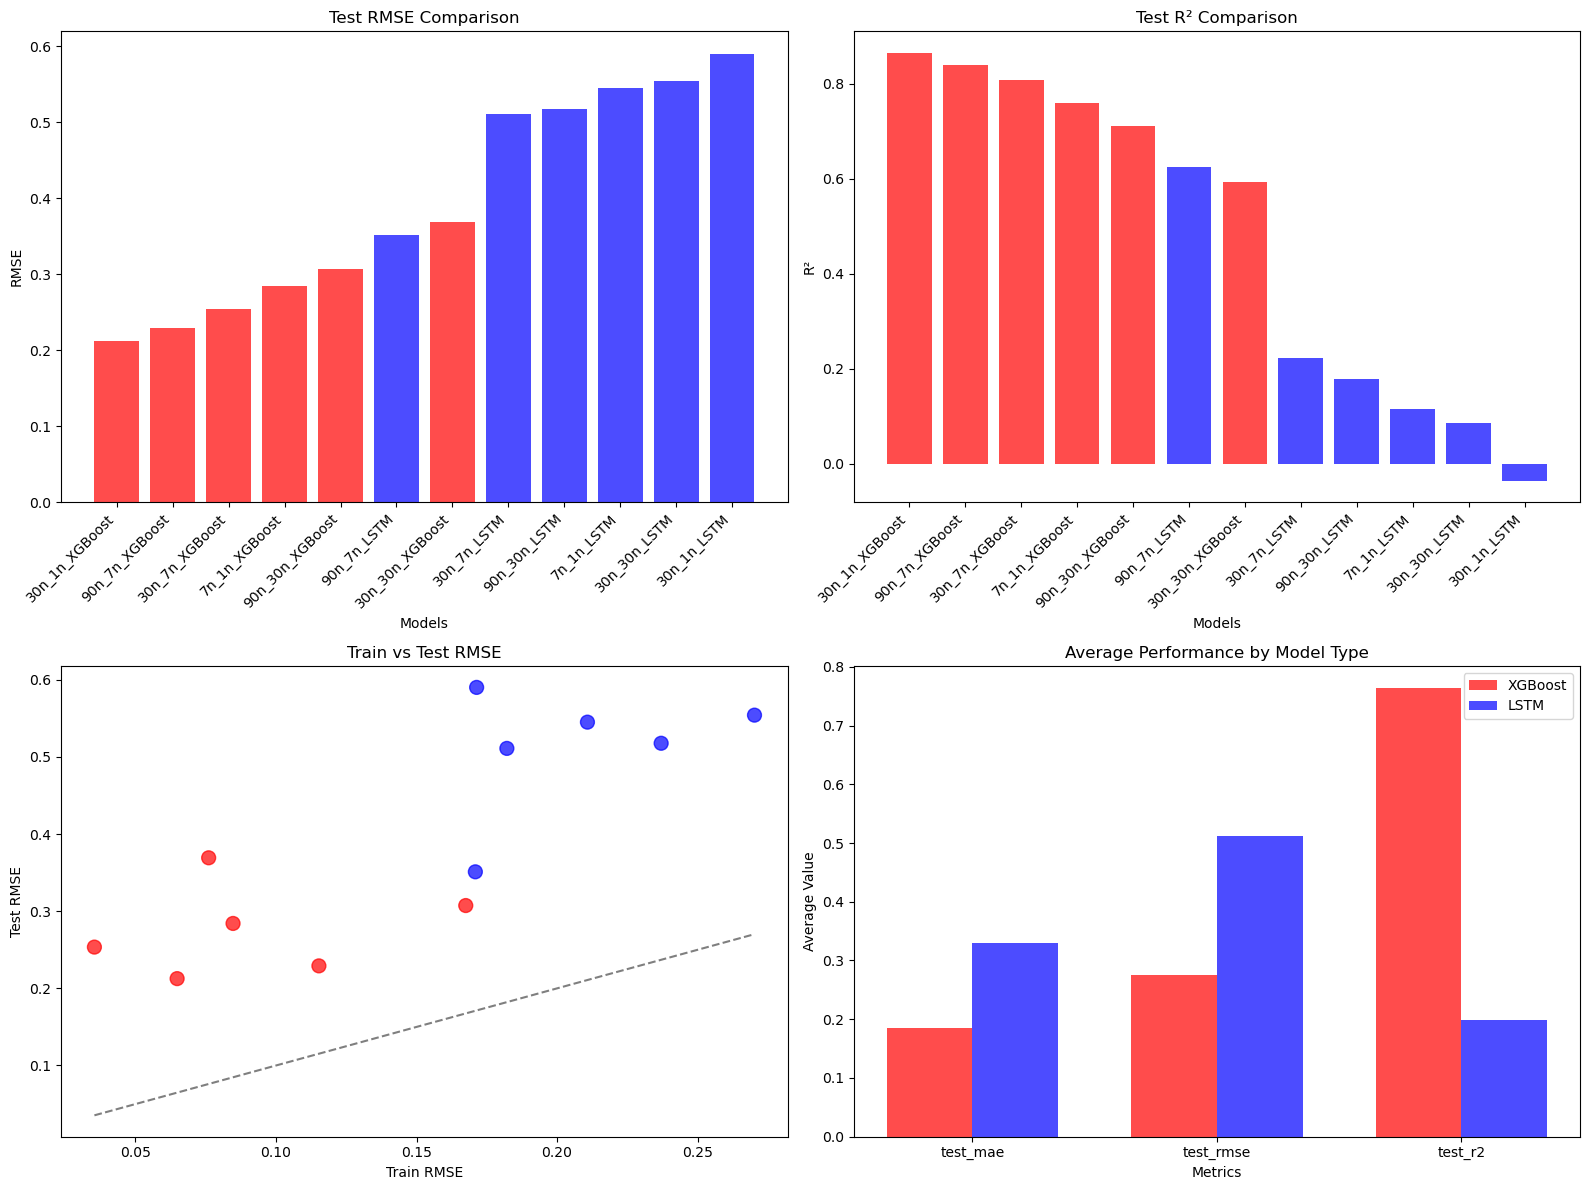

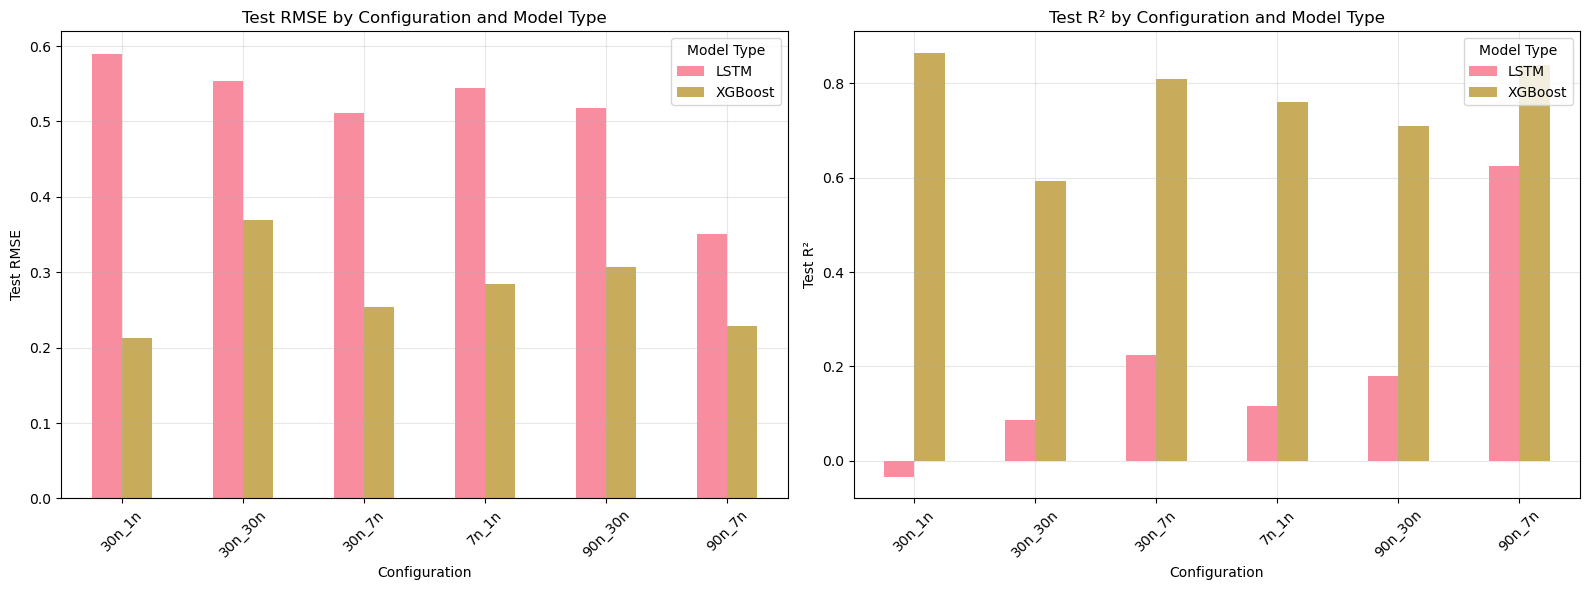

In [5]:
if not evaluator.results_df.empty:
    # Static plots
    fig = evaluator.plot_performance_comparison()
    
    # Additional analysis plots
    df = evaluator.results_df.copy()
    
    # Model type comparison by configuration
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # RMSE comparison
    pivot_rmse = df.pivot(index='config_name', columns='model_type', values='test_rmse')
    pivot_rmse.plot(kind='bar', ax=axes[0], alpha=0.8)
    axes[0].set_title('Test RMSE by Configuration and Model Type')
    axes[0].set_xlabel('Configuration')
    axes[0].set_ylabel('Test RMSE')
    axes[0].legend(title='Model Type')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # R² comparison
    pivot_r2 = df.pivot(index='config_name', columns='model_type', values='test_r2')
    pivot_r2.plot(kind='bar', ax=axes[1], alpha=0.8)
    axes[1].set_title('Test R² by Configuration and Model Type')
    axes[1].set_xlabel('Configuration')
    axes[1].set_ylabel('Test R²')
    axes[1].legend(title='Model Type')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Interactive Dashboard

In [6]:
if not evaluator.results_df.empty:
    # Interactive comparison dashboard
    print("\n🎯 INTERACTIVE PERFORMANCE DASHBOARD")
    print("(Các biểu đồ tương tác sẽ hiển thị nếu chạy trong Jupyter)")
    
    try:
        interactive_fig = evaluator.create_interactive_comparison()
    except Exception as e:
        print(f"Lỗi tạo interactive plots: {e}")
        print("Có thể do thiếu plotly hoặc chạy trong môi trường không hỗ trợ")


🎯 INTERACTIVE PERFORMANCE DASHBOARD
(Các biểu đồ tương tác sẽ hiển thị nếu chạy trong Jupyter)
Lỗi tạo interactive plots: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Có thể do thiếu plotly hoặc chạy trong môi trường không hỗ trợ


## Phân tích Input Length vs Prediction Horizon


PHÂN TÍCH INPUT LENGTH vs PREDICTION HORIZON

🔍 Hiệu suất theo Input Length (N days):
model_type      LSTM   XGBoost
N_days                        
7           0.545056  0.284123
30          0.551751  0.278433
90          0.434369  0.268235

🎯 Hiệu suất theo Prediction Horizon (M days):
model_type      LSTM   XGBoost
M_days                        
1           0.567577  0.248364
7           0.431039  0.241300
30          0.535907  0.338282


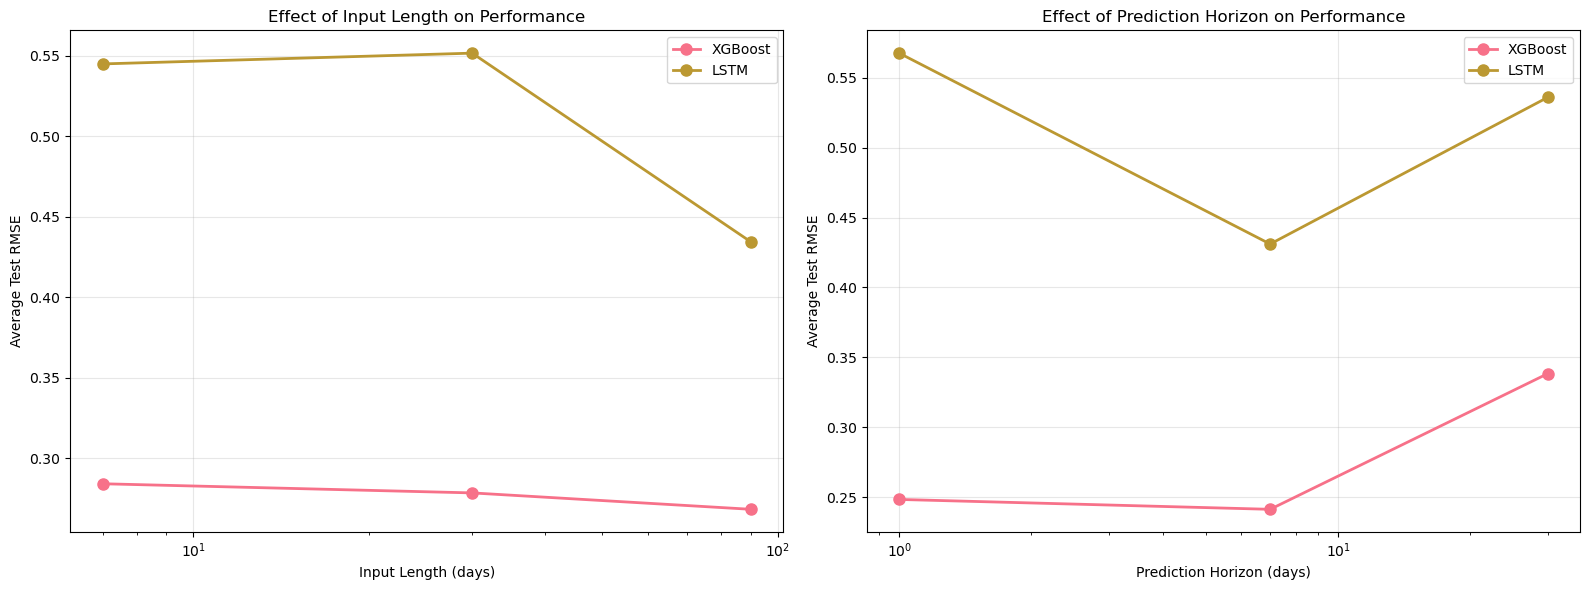

In [7]:
if not evaluator.results_df.empty:
    print("\n" + "="*60)
    print("PHÂN TÍCH INPUT LENGTH vs PREDICTION HORIZON")
    print("="*60)
    
    # Extract N and M from config names
    df_analysis = evaluator.results_df.copy()
    df_analysis['N_days'] = df_analysis['config_name'].str.extract(r'(\d+)n_').astype(int)
    df_analysis['M_days'] = df_analysis['config_name'].str.extract(r'_(\d+)n$').astype(int)
    
    # Analysis by input length
    print("\n🔍 Hiệu suất theo Input Length (N days):")
    n_analysis = df_analysis.groupby(['N_days', 'model_type'])['test_rmse'].mean().unstack()
    print(n_analysis.round(6))
    
    # Analysis by prediction horizon
    print("\n🎯 Hiệu suất theo Prediction Horizon (M days):")
    m_analysis = df_analysis.groupby(['M_days', 'model_type'])['test_rmse'].mean().unstack()
    print(m_analysis.round(6))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Input length effect
    for model_type in df_analysis['model_type'].unique():
        data = df_analysis[df_analysis['model_type'] == model_type]
        input_effect = data.groupby('N_days')['test_rmse'].mean()
        axes[0].plot(input_effect.index, input_effect.values, 'o-', label=model_type, linewidth=2, markersize=8)
    
    axes[0].set_xlabel('Input Length (days)')
    axes[0].set_ylabel('Average Test RMSE')
    axes[0].set_title('Effect of Input Length on Performance')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    
    # Prediction horizon effect
    for model_type in df_analysis['model_type'].unique():
        data = df_analysis[df_analysis['model_type'] == model_type]
        horizon_effect = data.groupby('M_days')['test_rmse'].mean()
        axes[1].plot(horizon_effect.index, horizon_effect.values, 'o-', label=model_type, linewidth=2, markersize=8)
    
    axes[1].set_xlabel('Prediction Horizon (days)')
    axes[1].set_ylabel('Average Test RMSE')
    axes[1].set_title('Effect of Prediction Horizon on Performance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')
    
    plt.tight_layout()
    plt.show()

## Model Strengths & Weaknesses Analysis

In [8]:
if not evaluator.results_df.empty:
    print("\n" + "="*60)
    print("PHÂN TÍCH STRENGTHS & WEAKNESSES")
    print("="*60)
    
    # Overall model type comparison
    model_comparison = evaluator.results_df.groupby('model_type').agg({
        'test_rmse': ['mean', 'std', 'min', 'max'],
        'test_r2': ['mean', 'std', 'min', 'max'],
        'test_mae': ['mean', 'std', 'min', 'max']
    }).round(6)
    
    print("\n📊 Overall Statistics by Model Type:")
    print(model_comparison)
    
    # Win/Loss analysis
    wins = {'XGBoost': 0, 'LSTM': 0}
    config_wins = {}
    
    for config in evaluator.results_df['config_name'].unique():
        config_data = evaluator.results_df[evaluator.results_df['config_name'] == config]
        if len(config_data) == 2:  # Both models available
            best_model = config_data.loc[config_data['test_rmse'].idxmin(), 'model_type']
            wins[best_model] += 1
            config_wins[config] = best_model
    
    print(f"\n🏆 Win/Loss Record:")
    print(f"XGBoost wins: {wins['XGBoost']} configurations")
    print(f"LSTM wins: {wins['LSTM']} configurations")
    
    print(f"\nDetailed wins by configuration:")
    for config, winner in config_wins.items():
        print(f"  {config}: {winner}")
    
    # Create summary insights
    print("\n" + "="*60)
    print("INSIGHTS VÀ KHUYẾN NGHỊ")
    print("="*60)
    
    best_overall = evaluator.results_df.loc[evaluator.results_df['test_rmse'].idxmin()]
    
    print(f"\n🎯 Best Overall Model:")
    print(f"   {best_overall['config_name']} - {best_overall['model_type']}")
    print(f"   RMSE: {best_overall['test_rmse']:.6f} m")
    print(f"   R²: {best_overall['test_r2']:.6f}")
    
    # Model-specific insights
    xgb_avg_rmse = evaluator.results_df[evaluator.results_df['model_type'] == 'XGBoost']['test_rmse'].mean()
    lstm_avg_rmse = evaluator.results_df[evaluator.results_df['model_type'] == 'LSTM']['test_rmse'].mean()
    
    print(f"\n🤖 XGBoost Analysis:")
    print(f"   Average RMSE: {xgb_avg_rmse:.6f}")
    print(f"   Strengths: Fast training, good interpretability, handles tabular data well")
    print(f"   Best for: Short to medium-term predictions with clear feature importance")
    
    print(f"\n🧠 LSTM Analysis:")
    print(f"   Average RMSE: {lstm_avg_rmse:.6f}")
    print(f"   Strengths: Captures temporal patterns, good for sequential data")
    print(f"   Best for: Complex temporal relationships, longer sequences")
    
    if xgb_avg_rmse < lstm_avg_rmse:
        improvement = ((lstm_avg_rmse - xgb_avg_rmse) / lstm_avg_rmse) * 100
        print(f"\n💡 Overall: XGBoost outperforms LSTM by {improvement:.2f}% on average")
    else:
        improvement = ((xgb_avg_rmse - lstm_avg_rmse) / xgb_avg_rmse) * 100
        print(f"\n💡 Overall: LSTM outperforms XGBoost by {improvement:.2f}% on average")


PHÂN TÍCH STRENGTHS & WEAKNESSES

📊 Overall Statistics by Model Type:
           test_rmse                                 test_r2            \
                mean       std       min       max      mean       std   
model_type                                                               
LSTM        0.511508  0.083549  0.351054  0.590098  0.198840  0.226561   
XGBoost     0.275982  0.057380  0.212606  0.369226  0.763149  0.099936   

                                test_mae                                
                 min       max      mean       std       min       max  
model_type                                                              
LSTM       -0.035262  0.624388  0.329179  0.060727  0.213215  0.386661  
XGBoost     0.593873  0.865615  0.184835  0.056550  0.124513  0.271261  

🏆 Win/Loss Record:
XGBoost wins: 6 configurations
LSTM wins: 0 configurations

Detailed wins by configuration:
  30n_1n: XGBoost
  30n_30n: XGBoost
  90n_30n: XGBoost
  90n_7n: XGBoost
  30n_7

## Export Comparison Report

In [9]:
if not evaluator.results_df.empty:
    # Save detailed comparison report
    report_path = evaluator.save_comparison_report("water_level_prediction_model_comparison.html")
    
    # Analyze detailed grid search results
    print("\n" + "="*60)
    print("DETAILED GRID SEARCH ANALYSIS")
    print("="*60)
    
    detailed_analysis = evaluator.analyze_detailed_grid_search()
    
    # Save detailed grid search analysis
    detailed_report_path = evaluator.save_detailed_analysis_report("detailed_grid_search_analysis.html")
    
    # Save results as CSV for further analysis
    results_path = "../models/all_models_comparison.csv"
    evaluator.results_df.to_csv(results_path, index=False)
    
    # Save detailed grid search results as Excel workbook for easy analysis
    excel_path = "../models/detailed_grid_search_results.xlsx"
    if evaluator.detailed_results:
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # Save summary
            evaluator.results_df.to_excel(writer, sheet_name='Summary', index=False)
            
            # Save each detailed result as separate sheet
            for key, detailed_df in evaluator.detailed_results.items():
                sheet_name = key.replace('_cv', '_CV').replace('_grid', '_Grid')[:31]  # Excel sheet name limit
                detailed_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"\n📋 Detailed results saved to Excel: {excel_path}")
    
    print(f"\n📋 Báo cáo đã được lưu:")
    print(f"   HTML Report: {report_path}")
    print(f"   Detailed Analysis: {detailed_report_path}")
    print(f"   CSV Data: {results_path}")
    if evaluator.detailed_results:
        print(f"   Excel Workbook: {excel_path}")
    
    # Create summary for README or documentation
    summary_text = f"""
# Water Level Prediction Models - Performance Summary

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Best Performing Models

"""
    
    top_3 = evaluator.results_df.nsmallest(3, 'test_rmse')
    for i, (_, model) in enumerate(top_3.iterrows()):
        medal = ["🥇", "🥈", "🥉"][i]
        summary_text += f"{medal} **{model['config_name']} - {model['model_type']}**\n"
        summary_text += f"   - RMSE: {model['test_rmse']:.6f} m\n"
        summary_text += f"   - R²: {model['test_r2']:.6f}\n"
        
        # Add grid search info if available
        if 'cv_combinations' in model and model['cv_combinations'] > 0:
            summary_text += f"   - CV combinations tested: {model['cv_combinations']}\n"
        if 'grid_combinations' in model and model['grid_combinations'] > 0:
            summary_text += f"   - Grid combinations tested: {model['grid_combinations']}\n"
        summary_text += "\n"
    
    summary_text += f"""
## Model Statistics

- Total models evaluated: {len(evaluator.results_df)}
- Configurations tested: {evaluator.results_df['config_name'].nunique()}
- XGBoost average RMSE: {evaluator.results_df[evaluator.results_df['model_type'] == 'XGBoost']['test_rmse'].mean():.6f}
- LSTM average RMSE: {evaluator.results_df[evaluator.results_df['model_type'] == 'LSTM']['test_rmse'].mean():.6f}

## Grid Search Summary

"""
    
    # Add grid search statistics
    xgb_models = evaluator.results_df[evaluator.results_df['model_type'] == 'XGBoost']
    lstm_models = evaluator.results_df[evaluator.results_df['model_type'] == 'LSTM']
    
    if 'cv_combinations' in xgb_models.columns:
        total_xgb_combinations = xgb_models['cv_combinations'].sum()
        summary_text += f"- Total XGBoost CV combinations tested: {total_xgb_combinations}\n"
        
    if 'grid_combinations' in lstm_models.columns:
        total_lstm_combinations = lstm_models['grid_combinations'].sum()
        summary_text += f"- Total LSTM grid combinations tested: {total_lstm_combinations}\n"
    
    summary_text += f"""

## Recommendations

Based on the comprehensive evaluation, the recommended approach for water level prediction depends on the specific use case:

- **For operational deployment**: Use the best performing model ({top_3.iloc[0]['config_name']} - {top_3.iloc[0]['model_type']})
- **For interpretability**: Consider XGBoost models for feature importance analysis
- **For complex temporal patterns**: LSTM models may capture longer-term dependencies better

## Files Generated

- `water_level_prediction_model_comparison.html`: Main comparison report
- `detailed_grid_search_analysis.html`: Detailed grid search analysis
- `all_models_comparison.csv`: Summary results in CSV format
- `detailed_grid_search_results.xlsx`: All grid search results in Excel format
- `model_comparison_summary.md`: This summary file
"""
    
    with open('../models/model_comparison_summary.md', 'w') as f:
        f.write(summary_text)
    
    print(f"   Summary: ../models/model_comparison_summary.md")
    
    print("\n✅ Model comparison analysis completed!")
    print("\n💡 Tip: Open the Excel file to explore all grid search combinations in detail!")


=== MODEL COMPARISON (sorted by Test RMSE) ===
config_name model_type  test_mae  test_rmse   test_r2
     30n_1n    XGBoost  0.124513   0.212606  0.865615
     90n_7n    XGBoost  0.152529   0.229131  0.839985
     30n_7n    XGBoost  0.146621   0.253469  0.809011
      7n_1n    XGBoost  0.180669   0.284123  0.759842
    90n_30n    XGBoost  0.233413   0.307339  0.710566
     90n_7n       LSTM  0.213215   0.351054  0.624388
    30n_30n    XGBoost  0.271261   0.369226  0.593873
     30n_7n       LSTM  0.321680   0.511024  0.223677
    90n_30n       LSTM  0.348969   0.517683  0.178812
      7n_1n       LSTM  0.342985   0.545056  0.116173
    30n_30n       LSTM  0.386661   0.554130  0.085253
     30n_1n       LSTM  0.361566   0.590098 -0.035262
Comparison report saved to: ../models/water_level_prediction_model_comparison.html

DETAILED GRID SEARCH ANALYSIS

DETAILED GRID SEARCH ANALYSIS

🔍 Analysis for 30n_1n_xgb:
   Total combinations tested: 81
   Best CV score: -0.026911
   Worst CV score

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
if not evaluator.results_df.empty and evaluator.detailed_results:
    print("\n" + "="*60)
    print("GRID SEARCH STATISTICS SUMMARY")
    print("="*60)
    
    # Overall statistics
    total_combinations = 0
    xgb_combinations = 0
    lstm_combinations = 0
    
    for key, detailed_df in evaluator.detailed_results.items():
        total_combinations += len(detailed_df)
        if 'cv' in key:
            xgb_combinations += len(detailed_df)
        elif 'grid' in key:
            lstm_combinations += len(detailed_df)
    
    print(f"📊 Overall Grid Search Statistics:")
    print(f"   Total parameter combinations tested: {total_combinations}")
    print(f"   XGBoost CV combinations: {xgb_combinations}")
    print(f"   LSTM Grid combinations: {lstm_combinations}")
    
    # Model-specific analysis
    if xgb_combinations > 0:
        print(f"\n🤖 XGBoost Grid Search Analysis:")
        xgb_keys = [k for k in evaluator.detailed_results.keys() if 'cv' in k]
        for key in xgb_keys:
            detailed_df = evaluator.detailed_results[key]
            config_name = key.replace('_cv', '')
            
            if 'mean_test_score' in detailed_df.columns:
                best_score = detailed_df['mean_test_score'].max()
                worst_score = detailed_df['mean_test_score'].min()
                mean_score = detailed_df['mean_test_score'].mean()
                std_score = detailed_df['mean_test_score'].std()
                
                print(f"   {config_name}:")
                print(f"     Combinations: {len(detailed_df)}")
                print(f"     Best CV score: {best_score:.6f}")
                print(f"     Mean CV score: {mean_score:.6f} ± {std_score:.6f}")
                print(f"     Score range: {best_score - worst_score:.6f}")
                
                # Most important parameters
                if 'params' in detailed_df.columns:
                    params_analysis = []
                    for _, row in detailed_df.iterrows():
                        params = eval(row['params']) if isinstance(row['params'], str) else row['params']
                        for param, value in params.items():
                            params_analysis.append({
                                'param': param,
                                'value': value,
                                'score': row['mean_test_score']
                            })
                    
                    if params_analysis:
                        params_df = pd.DataFrame(params_analysis)
                        for param in params_df['param'].unique():
                            param_data = params_df[params_df['param'] == param]
                            best_value = param_data.loc[param_data['score'].idxmax(), 'value']
                            print(f"     Best {param}: {best_value}")
    
    if lstm_combinations > 0:
        print(f"\n🧠 LSTM Grid Search Analysis:")
        lstm_keys = [k for k in evaluator.detailed_results.keys() if 'grid' in k]
        for key in lstm_keys:
            detailed_df = evaluator.detailed_results[key]
            config_name = key.replace('_grid', '')
            
            if 'val_loss' in detailed_df.columns:
                best_loss = detailed_df['val_loss'].min()  # Lower is better
                worst_loss = detailed_df['val_loss'].max()
                mean_loss = detailed_df['val_loss'].mean()
                std_loss = detailed_df['val_loss'].std()
                
                print(f"   {config_name}:")
                print(f"     Combinations: {len(detailed_df)}")
                print(f"     Best validation loss: {best_loss:.6f}")
                print(f"     Mean validation loss: {mean_loss:.6f} ± {std_loss:.6f}")
                print(f"     Loss range: {worst_loss - best_loss:.6f}")
                
                # Most important parameters
                if 'params' in detailed_df.columns:
                    params_analysis = []
                    for _, row in detailed_df.iterrows():
                        params = eval(row['params']) if isinstance(row['params'], str) else row['params']
                        for param, value in params.items():
                            params_analysis.append({
                                'param': param,
                                'value': value,
                                'loss': row['val_loss']
                            })
                    
                    if params_analysis:
                        params_df = pd.DataFrame(params_analysis)
                        for param in params_df['param'].unique():
                            param_data = params_df[params_df['param'] == param]
                            best_value = param_data.loc[param_data['loss'].idxmin(), 'value']
                            print(f"     Best {param}: {best_value}")
    
    # Create visualization of parameter importance
    if evaluator.detailed_results:
        print(f"\n📈 Parameter Impact Analysis:")
        
        # Analyze which parameters have the most impact on performance
        all_param_impacts = {}
        
        for key, detailed_df in evaluator.detailed_results.items():
            if 'params' not in detailed_df.columns:
                continue
                
            config_name = key.replace('_cv', '').replace('_grid', '')
            score_col = 'mean_test_score' if 'cv' in key else 'val_loss'
            
            if score_col not in detailed_df.columns:
                continue
            
            for _, row in detailed_df.iterrows():
                params = eval(row['params']) if isinstance(row['params'], str) else row['params']
                score = row[score_col]
                
                for param, value in params.items():
                    param_key = f"{config_name}_{param}"
                    if param_key not in all_param_impacts:
                        all_param_impacts[param_key] = []
                    all_param_impacts[param_key].append((value, score))
        
        # Find parameters with highest variance in performance
        param_variances = {}
        for param_key, value_score_pairs in all_param_impacts.items():
            if len(value_score_pairs) > 1:
                scores = [score for _, score in value_score_pairs]
                variance = np.var(scores)
                param_variances[param_key] = variance
        
        if param_variances:
            sorted_params = sorted(param_variances.items(), key=lambda x: x[1], reverse=True)
            print("   Parameters with highest impact on performance (by variance):")
            for param, variance in sorted_params[:5]:
                print(f"     {param}: variance = {variance:.8f}")

else:
    print("⚠️  No detailed grid search results available.")
    print("   Make sure to retrain models with the updated trainers to get detailed results.")


GRID SEARCH STATISTICS SUMMARY
📊 Overall Grid Search Statistics:
   Total parameter combinations tested: 810
   XGBoost CV combinations: 486
   LSTM Grid combinations: 324

🤖 XGBoost Grid Search Analysis:
   30n_1n_xgb:
     Combinations: 81
     Best CV score: -0.026911
     Mean CV score: -0.044984 ± 0.016389
     Score range: 0.059745
     Best learning_rate: 0.01
     Best max_depth: 7.0
     Best n_estimators: 500.0
     Best subsample: 0.5
   7n_1n_xgb:
     Combinations: 81
     Best CV score: -0.037427
     Mean CV score: -0.052794 ± 0.019923
     Score range: 0.084959
     Best learning_rate: 0.1
     Best max_depth: 3.0
     Best n_estimators: 500.0
     Best subsample: 1.0
   90n_30n_xgb:
     Combinations: 81
     Best CV score: -0.074348
     Mean CV score: -0.092666 ± 0.016143
     Score range: 0.056136
     Best learning_rate: 0.01
     Best max_depth: 5.0
     Best n_estimators: 500.0
     Best subsample: 0.8
   90n_7n_xgb:
     Combinations: 81
     Best CV score: -0.